
# GIBBS ILLUSTRATIVE EXAMPLE FOR A BIVARIATE NORMAL DISTRIBUTION, with KNOWN COVARIANCE matrix


In [9]:
install.packages("gganimate")
#install.packages("gganimate", repos='http://cran.us.r-project.org')
install.packages("gifski")
install.packages("png")

# Console: conda install -c conda-forge r-gganimate 
#  conda install -c r r-gganimate 



Warning message in install.packages("gifski"):
“installation of package ‘gifski’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [1]:
library(ggplot2)
library(tidyr)
library(MASS)
library(gridExtra)
library(gganimate)
library(gifski)
library(png)

Bivariate Normal Likelihood: 
$p(x|\mu,\Sigma) = (2\pi)^{-n} |\Sigma|^{-n/2} exp \left( -\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu) \right)$

for $x=\{(x_{11},x_{12}),\ldots,(x_{n1},x_{n2})\}$

For a non-informative prior, Posterior Distribution of $\mu=(\mu_1,\mu_2)$, given data $x$, and with known covariance matrix $\Sigma$:  $\mu |x \sim \mathcal{N} (\bar{x},\Sigma/\sqrt{n})$

In [2]:
# Parameters of a Normal distribution used as a toy target distribution
x <- c(0,0) # data (one point)
r <- 0.8
S <- diag(2)
S[1, 2] <- r
S[2, 1] <- r

Sample from the toy distribution to visualize 90% HPD interva

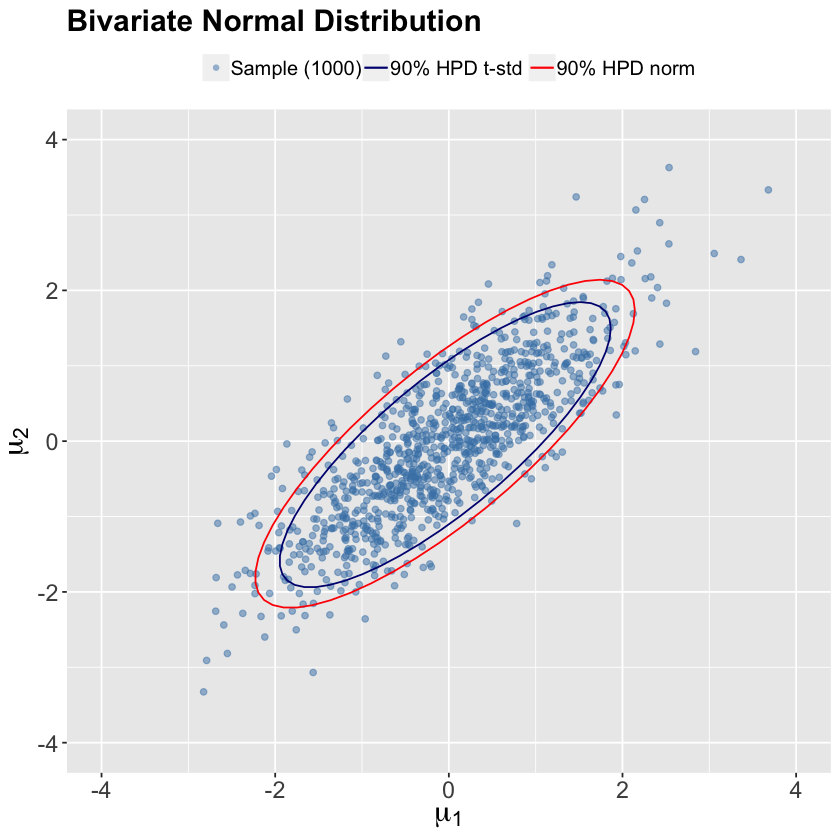

In [3]:
dft <- data.frame(mvrnorm(1000, c(0, 0), S)) # true dist. func.


ggplot(data = dft) +
  geom_point(aes(X1, X2, color ='1'),alpha = 0.5)+
  stat_ellipse(aes(x = X1, y = X2, color = '2'), level = 0.9) + # Compute normal confidence ellipses, default multivariate t-distribution 
  stat_ellipse(aes(x = X1, y = X2, color = '3'),level = 0.9, type = "norm") + #  multivariate normal distribution
  coord_cartesian(xlim = c(-4, 4), ylim = c(-4, 4)) +
  labs(x = expression(mu[1]), y = expression(mu[2])) +
  labs(title='Bivariate Normal Distribution') + 
  scale_color_manual(values=c('steelblue','navyblue','red'),labels = c('Sample (1000)','90% HPD t-std','90% HPD norm')) +
  guides(color = guide_legend(override.aes = list(
    shape = c(16, NA, NA), linetype = c(0, 1, 1)))) +
  theme(axis.text=element_text(size=14),
        axis.title = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.text= element_text(size = 12),
        legend.position = 'top', 
        legend.title = element_blank())

## Gibbs sampling for BIVARIATE NORMAL, with KNOWN COVARIANCE matrix

In this implementation one iteration updates only one parameter and one complete iteration updating both parameters takes two basic iterations. 
This implementation was used to make plotting of Gibbs sampler's zig-zagging. 
In plots you can implement this also by saving only the final state of complete iteration updating all parameters.

In [4]:
# Starting value of the chain
t1 <- -2.5
t2 <- 2.5
# Number of iterations.
M <- 2*2500


# Allocate memory for the samples
tt <- matrix(rep(0, 2*M), ncol = 2)

# Gibbs algorithm for a bivariate normal, with known S
# Conditional are normal distributions 
mygibbs <- function (niter,mu0, mu,S) #
{
  mat <- matrix(ncol = 2, nrow = niter+1)
  rho <- S[1,2] / sqrt(S[1,1]*S[2,2])
  s1 <- S[1,1]; s2 <- S[2,2]
  m1 <- mu0[1]; m2 <- mu0[2]
  mat[1, ] <- mu0 # Starting value of the chain
  for (i in 1:(niter/2)) {
    m1 <- rnorm(1, mu[1] + rho * sqrt(s1/s2)*(mat[2*i-1,2]-mu[2]), sqrt(s1*(1 - rho^2)))
    mat[2*i, ] <- c(m1, mat[2*i-1,2])
    m2 <- rnorm(1, mu[2] + rho * sqrt(s2/s1)*(m1-mu[1]), sqrt(s2*(1 - rho^2)))
    mat[2*i+1, ] <- c(m1, m2)
  }
  return(mat)
}


# Now run the algorithm 
tt <- mygibbs(niter=M,mu0=c(t1,t2),mu=x,S=S)

# tt

### Illustrate how the sampler works

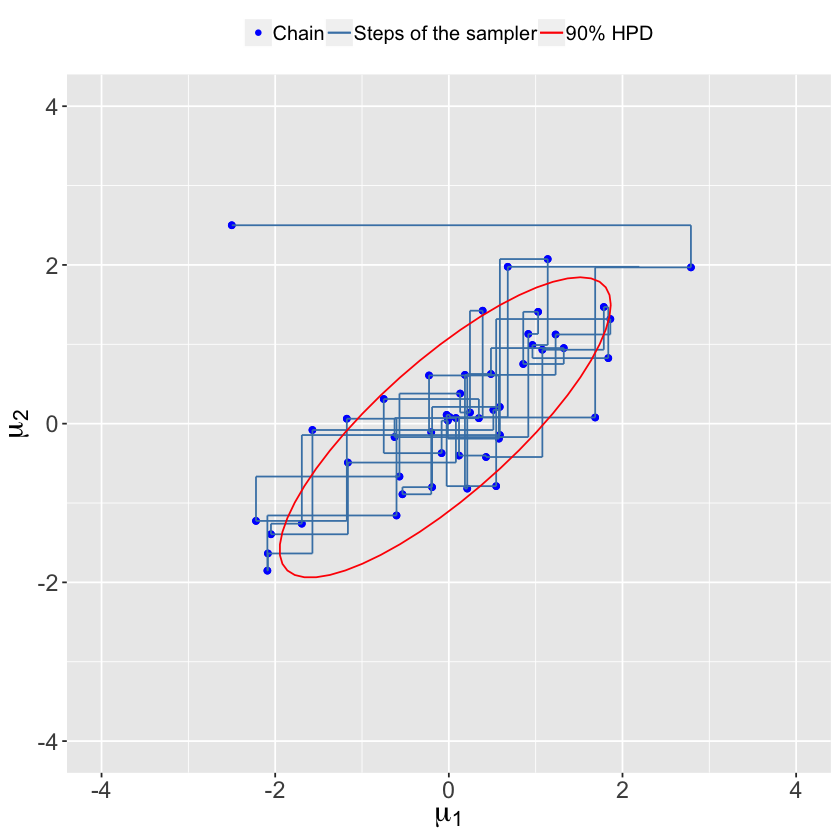

In [5]:
# Take the first 100 samples
# to illustrate how the sampler works
df100 <- data.frame(id=rep(1,100),
                    iter=1:100, 
                    th1 = tt[1:100, 1],
                    th2 = tt[1:100, 2],
                    th1l = c(tt[1, 1], tt[1:(100-1), 1]),
                    th2l = c(tt[1, 2], tt[1:(100-1), 2]))

# remove burn-in period of 50 first samples later
burn <- 50
# frame indices for the following plot
ind1 <- (1:50)*2-1
df100s <- df100
df100s[ind1+1,3:4]=df100s[ind1,3:4]

p1 <- ggplot() +
  geom_point(data = df100s, #df100[ind1,],
             aes(th1, th2, color ='1')) +
  geom_segment(data = df100, aes(x = th1, xend = th1l, color = '2',
                                 y = th2, yend = th2l)) +
  stat_ellipse(data = dft, aes(x = X1, y = X2, color = '3'), level = 0.9) +
  coord_cartesian(xlim = c(-4, 4), ylim = c(-4, 4)) +
  labs(x = expression(mu[1]), y = expression(mu[2])) +
  scale_color_manual(values = c('blue', 'steelblue','red'), 
                     labels = c('Chain', 'Steps of the sampler', '90% HPD')) +
  guides(color = guide_legend(override.aes = list(
    shape = c(16, NA, NA), linetype = c(0, 1, 1)))) +
  theme(axis.text=element_text(size=14),
        axis.title = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.text= element_text(size = 12),
        legend.position = 'top', 
        legend.title = element_blank())


# show the result
p1

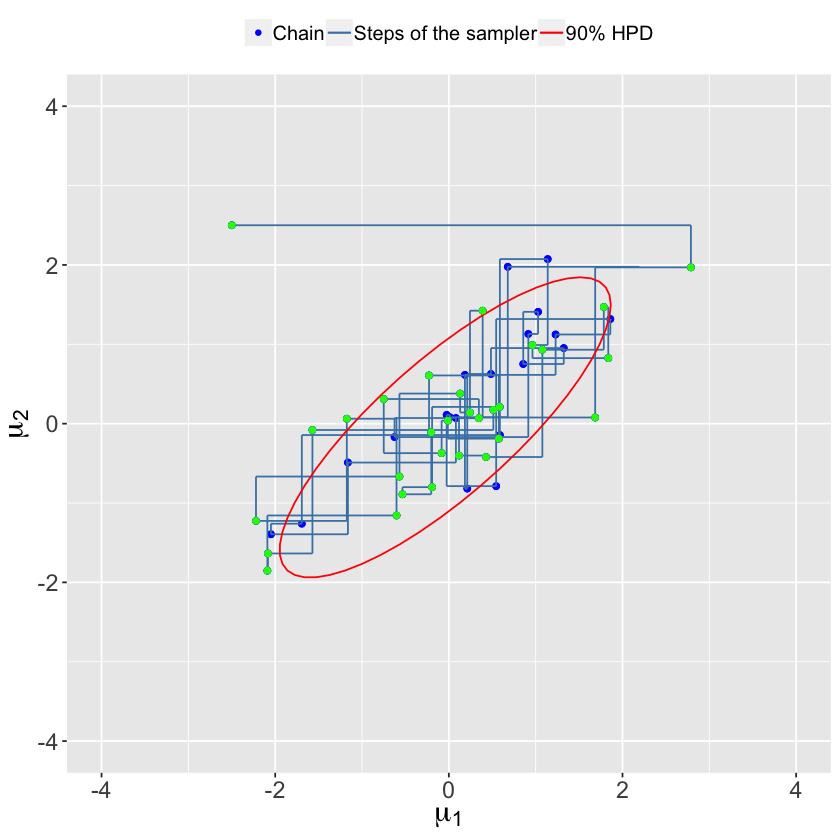

In [6]:
# highlight burn-in period of the 30 first samples with green
p1 + geom_point(data = df100[ind1[1:30],],
                aes(th1, th2), color = 'green')

In [10]:
#' The following generates a gif animation
#' of the steps of the sampler (might take 10 seconds).
#+ Gibbs (1)
animate(p1 +   
          transition_reveal(id=id, along=iter) +
          shadow_trail(0.01))

Warning message:


![SegmentLocal](Gibbs_animated.gif "segment")

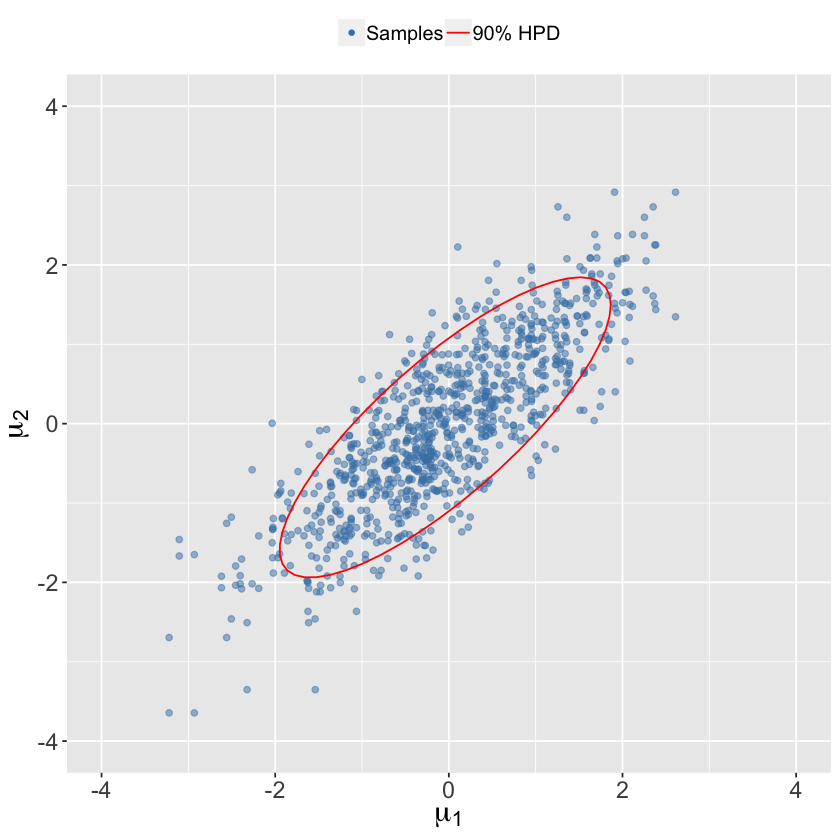

In [45]:
# show 950 draws after a burn-in period of
# 50 draws is removed
# take the first 1000 observations
s <- 1000
dfs <- data.frame(th1 = tt[1:s, 1], th2 = tt[1:s, 2]) # sampling distr. func.

ggplot() +
  geom_point(data = dfs[-(1:burn),],
             aes(th1, th2, color = '1'), alpha = 0.5) +
  stat_ellipse(data = dft, aes(x = X1, y = X2, color = '2'), level = 0.9) +
  coord_cartesian(xlim = c(-4, 4), ylim = c(-4, 4)) +
  labs(x = expression(mu[1]), y = expression(mu[2])) +
  scale_color_manual(values = c('steelblue', 'red'), labels = c('Samples', '90% HPD')) +
  guides(color = guide_legend(override.aes = list(
    shape = c(16, NA), linetype = c(0, 1), alpha = c(1, 1)))) +
  theme(axis.text=element_text(size=14),
        axis.title = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.text= element_text(size = 12),
        legend.position = 'top', 
        legend.title = element_blank())

### Assesing convergence:

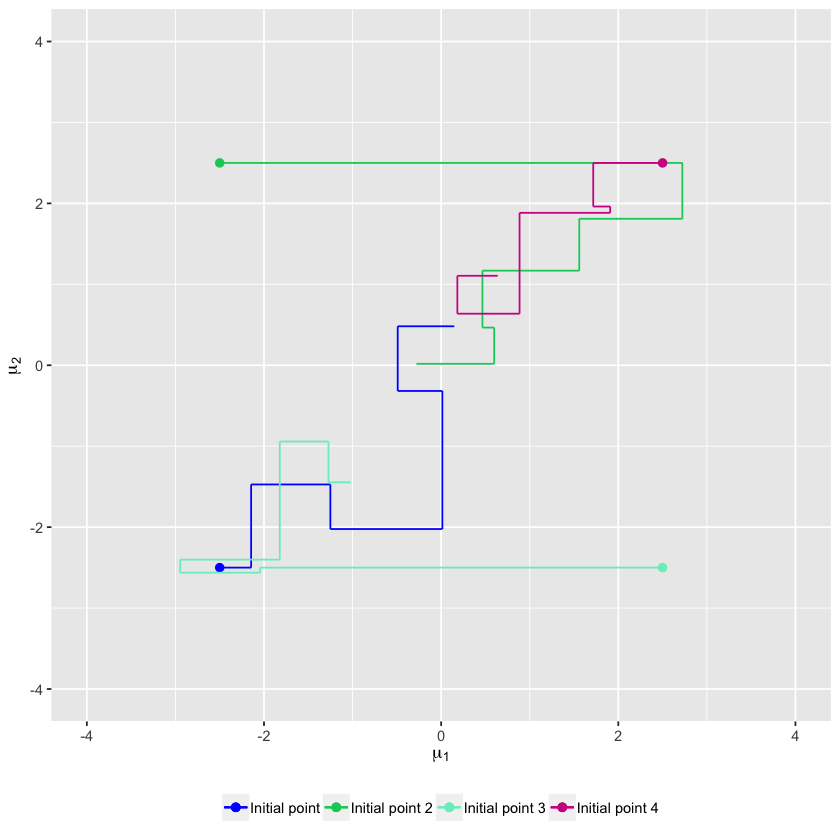

In [44]:
M <- 2*2500
initp <- array(c(-2.5,-2.5,2.5,2.5,-2.5,2.5,-2.5,2.5),dim=c(4,2))
tt <- matrix(rep(0, 2*4*(M+1)), ncol = 2*4)
for(i in 1:4) tt[,(2*i-1):(2*i)] <- mygibbs(niter=M,mu0=initp[i,],mu=x,S=S)

n=500
df <- data.frame(th1 = tt[1:n, 1],th2 = tt[1:n, 2],
                 th1l = c(tt[1, 1], tt[1:(n-1), 1]),th2l = c(tt[1, 2], tt[1:(n-1), 2]),
                 th1 = tt[1:n, 3],th2 = tt[1:n, 4],
                 th1l = c(tt[1, 3], tt[1:(n-1), 3]),th2l = c(tt[1, 4], tt[1:(n-1), 4]),
                 th1 = tt[1:n, 5],th2 = tt[1:n, 6],
                 th1l = c(tt[1, 5], tt[1:(n-1), 5]),th2l = c(tt[1, 6], tt[1:(n-1), 6]),
                 th1 = tt[1:n, 7],th2 = tt[1:n, 8],
                 th1l = c(tt[1, 7], tt[1:(n-1), 7]),th2l = c(tt[1, 8], tt[1:(n-1), 8]))

# Take the first 10 samples
p1 <- ggplot() +
  geom_point(data = df[1,],aes(x=th1,y=th2,color='1'),size =2) +
  geom_segment(data = df[1:10,], aes(x = th1, xend = th1l, color = '1',
                                 y = th2, yend = th2l)) +
  geom_point(data = df[1,],aes(x=th1.1,y=th2.1,color='2'),size =2) +
  geom_segment(data = df[1:10,], aes(x = th1.1, xend = th1l.1, color = '2',
                                     y = th2.1, yend = th2l.1)) +
  geom_point(data = df[1,],aes(x=th1.2,y=th2.2,color='3'),size =2) +
  geom_segment(data = df[1:10,], aes(x = th1.2, xend = th1l.2, color = '3',
                                     y = th2.2, yend = th2l.2)) +
  geom_point(data = df[1,],aes(x=th1.3,y=th2.3,color='4'),size =2) +
  geom_segment(data = df[1:10,], aes(x = th1.3, xend = th1l.3, color = '4',
                                     y = th2.3, yend = th2l.3)) +
  coord_cartesian(xlim = c(-4, 4), ylim = c(-4, 4)) + 
  labs(x = expression(mu[1]), y = expression(mu[2])) +
  scale_color_manual(values = c('blue', 'springgreen3','aquamarine2','violetred'), 
                     labels = c('Initial point', 'Initial point 2','Initial point 3', 'Initial point 4')) +
  theme(legend.position = 'bottom', legend.title = element_blank())

p1 


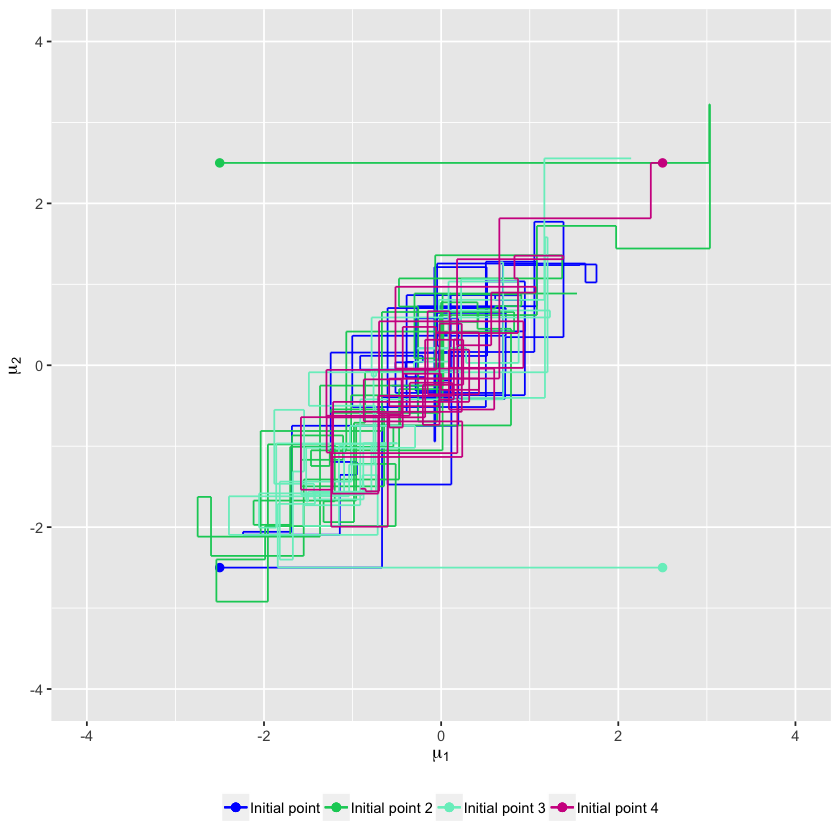

In [43]:
# Take the first 100 samples
p2 <- ggplot() +
  geom_point(data = df[1,],aes(x=th1,y=th2,color='1'),size =2) +
  geom_segment(data = df[1:100,], aes(x = th1, xend = th1l, color = '1',
                                     y = th2, yend = th2l)) +
  geom_point(data = df[1,],aes(x=th1.1,y=th2.1,color='2'),size =2) +
  geom_segment(data = df[1:100,], aes(x = th1.1, xend = th1l.1, color = '2',
                                     y = th2.1, yend = th2l.1)) +
  geom_point(data = df[1,],aes(x=th1.2,y=th2.2,color='3'),size =2) +
  geom_segment(data = df[1:100,], aes(x = th1.2, xend = th1l.2, color = '3',
                                     y = th2.2, yend = th2l.2)) +
  geom_point(data = df[1,],aes(x=th1.3,y=th2.3,color='4'),size =2) +
  geom_segment(data = df[1:100,], aes(x = th1.3, xend = th1l.3, color = '4',
                                     y = th2.3, yend = th2l.3)) +
  coord_cartesian(xlim = c(-4, 4), ylim = c(-4, 4)) + 
  labs(x = expression(mu[1]), y = expression(mu[2])) +
  scale_color_manual(values = c('blue', 'springgreen3','aquamarine2','violetred'), 
                     labels = c('Initial point', 'Initial point 2','Initial point 3', 'Initial point 4')) +
  theme(legend.position = 'bottom', legend.title = element_blank())

p2

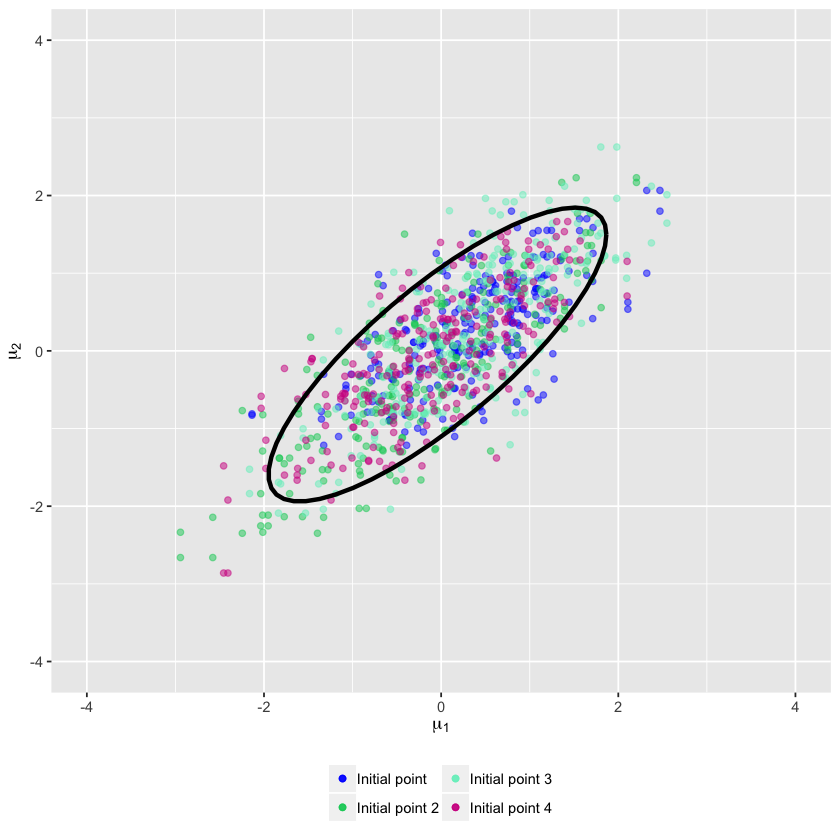

In [41]:
# Take the first 500 iterations (show only last half)
p3 <- ggplot() +
  geom_point(data = df[250:500,],aes(x=th1,y=th2,color='1'),alpha =0.5) +
  geom_point(data = df[250:500,],aes(x=th1.1,y=th2.1,color='2'),alpha =0.5) +
  geom_point(data = df[250:500,],aes(x=th1.2,y=th2.2,color='3'),alpha =0.5) +
  geom_point(data = df[250:500,],aes(x=th1.3,y=th2.3,color='4'),alpha =0.5) +
  stat_ellipse(data = dft, aes(x = X1, y = X2), col='black',size=1.25,level = 0.9) +
  coord_cartesian(xlim = c(-4, 4), ylim = c(-4, 4)) + 
  labs(x = expression(mu[1]), y = expression(mu[2])) +
  scale_color_manual(values = c('blue', 'springgreen3','aquamarine2','violetred'), 
                     labels = c('Initial point', 'Initial point 2','Initial point 3', 'Initial point 4')) +
  guides(color=guide_legend(ncol=2))+
  theme(legend.position = 'bottom', legend.title = element_blank())

p3
#grid.arrange(p1,p2,p3,ncol=3)

### Visual convergence diagnostics

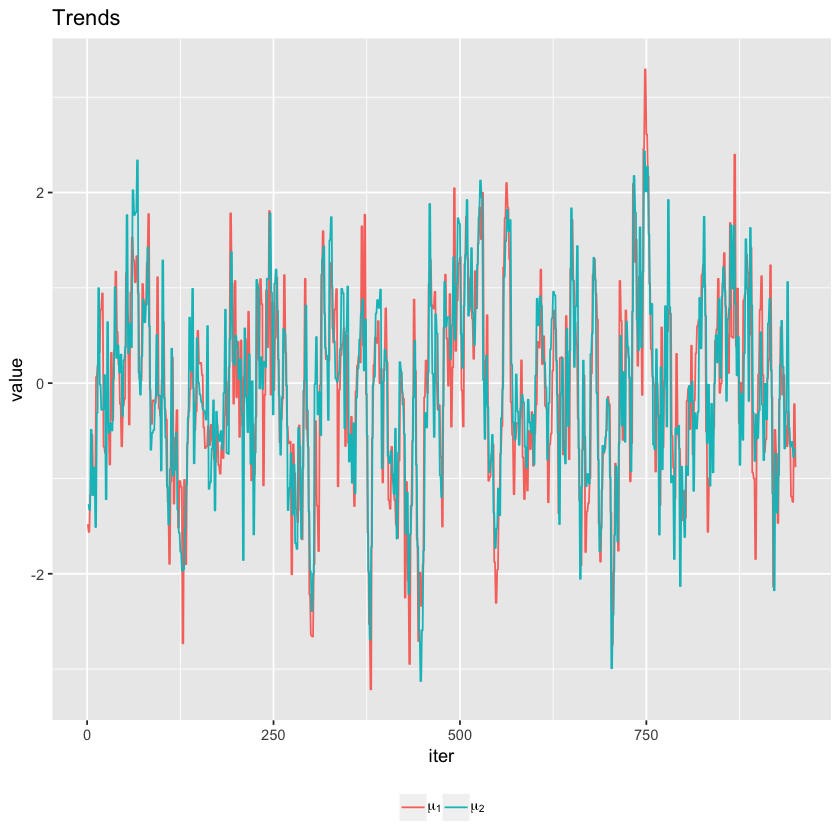

In [40]:
# collapse the data frame with row numbers augmented (within)
# into key-value pairs for visualizing the chains (gather)
dfb <- dfs[-(1:burn),]
sb <- s-burn
# The pipe operator, %>%, takes the result of the left-hand side 
# and uses it as the first argument of the function on the right-hand side.
dfch <- within(dfb, iter <- 1:sb) %>% gather(grp, value, -iter) 
# Visualize the chains
ggplot(data = dfch) +
  geom_line(aes(iter, value, color = grp)) +
  labs(title = 'Trends') +
  scale_color_discrete(labels = c(expression(mu[1]),expression(mu[2]))) +
  theme(legend.position = 'bottom', legend.title = element_blank())


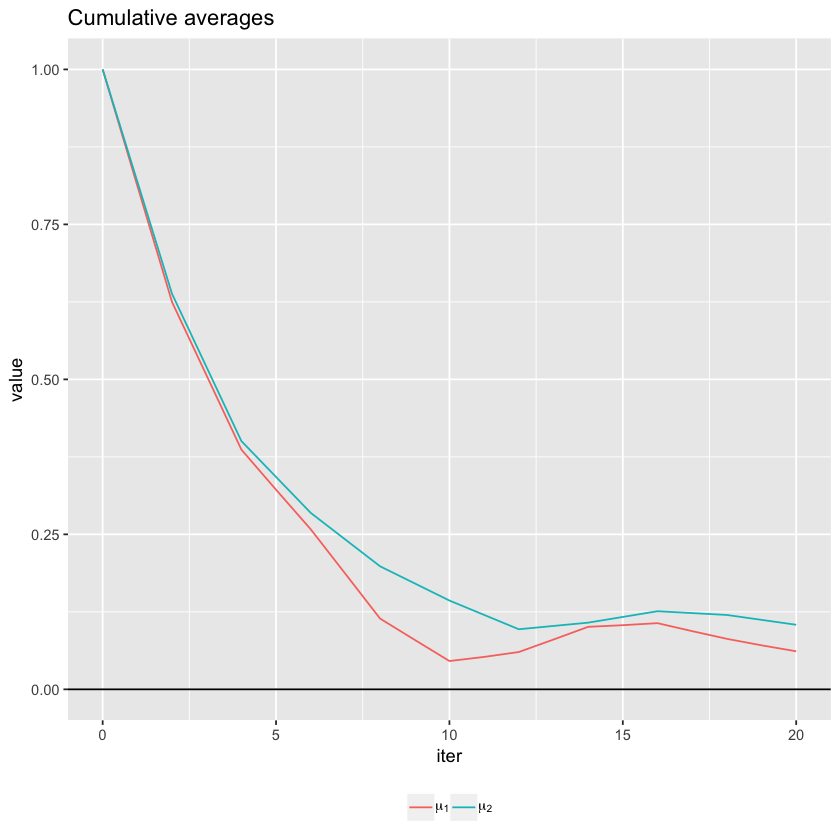

In [39]:
# Another data frame for visualizing the estimate of
# the autocorrelation function
nlags <- 20
dfa <- sapply(dfb, function(x) acf(x, lag.max = nlags, plot = F)$acf) %>%
  data.frame(iter = 0:(nlags)) %>% gather(grp, value, -iter)
# Visualize the estimate of the autocorrelation function
ggplot(data = dfa) +
  geom_line(aes(iter, value, color = grp)) +
  geom_hline(aes(yintercept = 0)) +
  labs(title = 'Cumulative averages') +
  scale_color_discrete(labels = c(expression(mu[1]),expression(mu[2]))) +
  theme(legend.position = 'bottom', legend.title = element_blank())



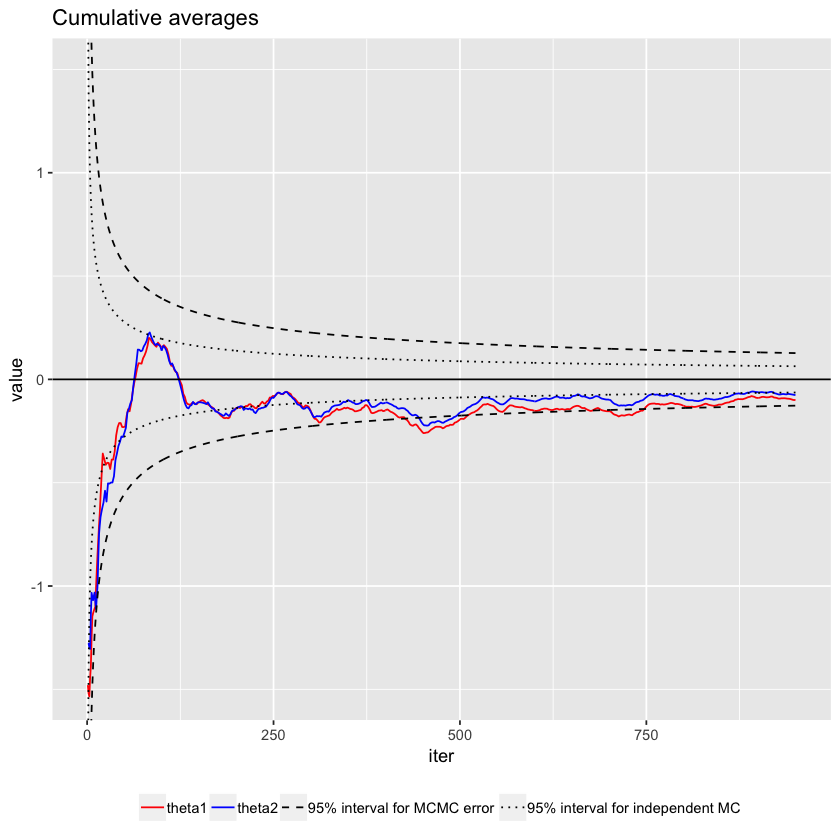

In [38]:
# A third data frame to visualize the cumulative averages
# and the 95% intervals
dfca <- (cumsum(dfb) / (1:sb)) %>%
  within({iter <- 1:sb
          uppi <-  1.96/sqrt(1:sb)
          upp <- 1.96/(sqrt(1:sb/4))}) %>%
  gather(grp, value, -iter)

# Visualize the estimate of the ACF
ggplot() +
  geom_line(data = dfca, aes(iter, value, color = grp, linetype = grp)) +
  geom_line(aes(1:sb, -1.96/sqrt(1:sb/4)), linetype = 2) +
  geom_line(aes(1:sb, -1.96/sqrt(1:sb)), linetype = 3) +
  geom_hline(aes(yintercept = 0)) +
  coord_cartesian(ylim = c(-1.5, 1.5)) +
  labs(title = 'Cumulative averages') +
  scale_color_manual(values = c('red','blue',rep('black', 2)), 
                     labels = c(expression(mu[1]),expression(mu[2]),
                                '95% interval for MCMC error',
                                '95% interval for independent MC')) +
  scale_linetype_manual(values = c(1, 1, 2, 3), 
                        labels = c(expression(mu[1]),expression(mu[2]),
                                   '95% interval for MCMC error',
                                   '95% interval for independent MC')) +
  theme(legend.position = 'bottom', legend.title = element_blank())